# The astroImage Object #

The astroIm package rebolves around the astroImage class to manipulate fits files, and is tuned to particularly work in with Far-IR/Sub-mm images. Many of the methods provided are wrappers to astropy functions. Here we show what methods are available for an astroImage file. To finish the tutorial we show the case where you want to match the resolution and projection of one image to another.

This tutorial obtains data from the Dustpedia database, however, you can switch it to whatever fits file you want.


## Obtaining Data for this Tutorial ##

First we download example data from the dustpedia database of a SPIRE image of M100.

In [1]:
# import wget module to download data
import urllib.request
from os.path import join as pj

# set folder to store data
folder = "/home/gandalf/spxmws/Hard-Drive/dustpedia"

# download 250 and 500um data file
urllib.request.urlretrieve("http://www.astro.cf.ac.uk/pub/Matthew.Smith/web/astroIm/NGC4321_SPIRE_250.fits",pj(folder,"NGC4321_SPIRE_250.fits"))
urllib.request.urlretrieve("http://www.astro.cf.ac.uk/pub/Matthew.Smith/web/astroIm/NGC4321_SPIRE_500.fits",pj(folder,"NGC4321_SPIRE_500.fits"))


('/home/gandalf/spxmws/Hard-Drive/dustpedia/NGC4321_SPIRE_500.fits',
 <http.client.HTTPMessage at 0x152146c82400>)

<h2>Importing the module and loading an image</h2>

In the next box we will open a fits file. The code by defaults to loading the first extension, but other extensions can be loaded with the 'ext=X'. The code searches the header for the instrument, band and units of the image. If this information is not present, it can be added manually (see the commented line). astroImage can also take a astropy.fits hdu object.

In [3]:
# import module
from astroIm import astroImage

# load your fits file - adjust path to your fits file
fitsImage = astroImage(pj(folder,"NGC4321_SPIRE_250.fits"), dustpediaHeaderCorrect=True)

# load line with extra inputs defined
#fitsImage = astroImage("file.fits", ext=0, instrument='SPIRE', band=250, unit='Jy/pix', "FWHM":10.0)

# load from fits hdu
#fitsImage = astroImage(hduobject, load=False)

As mentioned the code attempts to ascertain the instrument and band (if not given when loading the image).

In [4]:
print("Instrument: ", fitsImage.instrument) 
print("      Band: ", fitsImage.band)

Instrument:  SPIRE
      Band:  250


<h2>Quick Look Plot</h2>

A function exists to get a quick look image using aplpy. The default output is to use a linear stretch:

INFO: Auto-setting vmin to -3.916e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.400e-02 [aplpy.core]


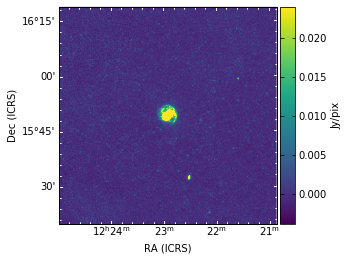

In [5]:
# default quick look plot
fitsImage.quicklookPlot()

Quite often it is better for large dynamic ranges to use a log scale. The quicklookPlot has a algorithm to estimate the best parameters for a logscale:

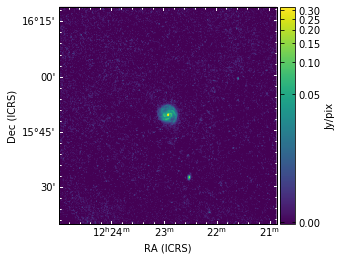

In [6]:
# default quick look plot with log scale
fitsImage.quicklookPlot(stretch='log')

As a final example we can specify the colour map through the cmap parameter, to hide the colourbar, and whether to zoom in on a certain region. The recentre parameter controls the zoom using a dictionary with RA, DEC and radius giving each quantity with a unit. For example:

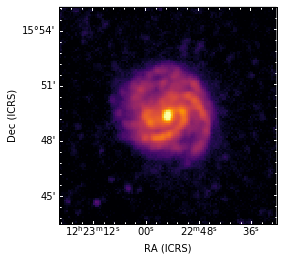

In [7]:
# import astropy units
import astropy.units as u

# call quick look plot with log scale, different colourmap,  and centre specified
fitsImage.quicklookPlot(stretch='log', cmap='inferno', hide_colourbar=True, recentre={"RA":185.72875*u.degree, "DEC":15.8225*u.degree, "rad":6.0*u.arcmin})

The user can also specify the following parameters in the method call:
  - *save*: use *save* to set the path where to save the plot.
  - *vmin*, *vmax*, *vmid*: the user can specify any of the minimum, maximum or middle (log only) of the colour bar. 
  - *facecolor*: use this parameter to set the background colour outside the images.
  - *nancolour*: use this parameter to set the NaN colour.

<h2>Accessing the image array or header</h2>

Similar to astropy the image array can be found using the image and header attributes. Here,we show this by getting the mean of the image, its unit, and a header keyword.

In [8]:
print("Image Mean: ", fitsImage.image.mean(), fitsImage.unit)
print("Image Reference Pix: (", fitsImage.header['CRPIX1'], ",", fitsImage.header['CRPIX2'], ")")

Image Mean:  8.698689370460493e-05 Jy/pix
Image Reference Pix: ( -498.0 , -4114.0 )


<h2>Get the Pixel Size</h2>

To get the pixel size of the image, the getPixelScale method. This value is recorded in the pixSize attribute.

In [9]:
# run method to get pixel sizes
fitsImage.getPixelScale()

# print the pixel size as attribute
print(fitsImage.pixSize)

6.0 arcsec


<h2>Converting Units</h2>

Possibly one of the most useful features of the astroImage class is that it provides an easy way to switch the image between different units. The user can provide the conversion to use or beam area to assume if desired (see commented version).

In [10]:
print("Initial Units: ", fitsImage.unit)
print("Peak Pixel: ", fitsImage.image.max(), fitsImage.unit, "\n")


# convert units to that desired
fitsImage.convertUnits("MJy/sr")

# if want to provide the conversion or beam area use the following inputs
#fitsImage.convertUnits("MJy/sr", conversion=1.0, beamArea=1.0)

print()
print("New Units: ", fitsImage.unit)
print("Peak Pixel: ", fitsImage.image.max(), fitsImage.unit, "\n")

Initial Units:  Jy/pix
Peak Pixel:  0.41581757264896013 Jy/pix 

Image converted to:  MJy/sr

New Units:  MJy/sr
Peak Pixel:  491.4174844578513 MJy/sr 



<h2>Simple Image Arithmatic</h2>

This method is a bit redundant, as you can get the image change it how you want and save it back. Alteratively, the imageManipulation method takes operation (either '+','-','*','/','$**$), followed by the value to use. Here we show standard method where we double the image and use the method to restore the image back.

In [11]:
# traditional (and probably more useful method)
fitsImage.image = fitsImage.image * 2.0

# using the method
fitsImage.imageManipulation("/",2.0)


<h2>Finding the Image Noise, Background Subtraction, and Aperture Photometry</h2>

The astro image package provides methods to find the noise in the background of an image, to background subtact an object and to perform aperture photometry. 

**Finding Background Value, Noise using Sigma-Clipping**

To find the noise, background level, and get a source mask, a method is provided which tries to identify emission from sources using the photutils make_source_mask task (which uses an image segmentation algorithm). With this mask applied we then use the astrop sigma_clipped_stats function to find the sigma-clipped median and standard deviation of the background. The parameters of these two methods can be adjusted (see commented command below).

The mask found is returned, that way the same source mask can be provided to use on another image via maskMatch parameter.

In [12]:
# first we will switch back to Jy/pix units
fitsImage.convertUnits('mJy/pix')

# run the background analysis to find background median, standard-deviation, and source mask
backMedian, backStd, mask = fitsImage.background_rms()

# this is the version of the command with all paramters.
# The parameters for the photutils make_source_mask are (snr, npixels, dilate_size)
# The parameters for the sigma_clipped_stats are (sigClip, interations)
# to provide a mask, give it via the maskMatch parameter.
#backMedian, backStd, mask = fitsImage.background_rms(self, snr=2, npixels=5, dilate_size=11, sigClip=3.0, iterations=20, maskMatch=None)


Image converted to:  mJy/pix


You can apply this background with the constantBackSub method, just give it the value to subtract. Although this method is redundant with the arithmetic method above.

**Ellipse Annulus Background**

You may wish to choose a background around a particular source, or prefer a more manual method. The ellipseAnnulusBackSub method allows you to specify an ellipical annulus which will subtract the background in this region from the image and if 'backNoise' is set to true the standard deviation is returned.

The parameters of the ellipse are provided in a dictionary:  
<pre>
ellipseAnnulusInfo = {"centreRA":123.1     # RA centre of ellipse in degrees  
                      "centreDEC":12.3     # DEC centre of ellipse in degrees  
                      "innerRad":[2.0,1.0] # The major and minor radius in arcmin of inner ellipse  
                      "outerRad":[3.0,2.0] # The major and minor radius in arcmin of outer ellipse  
                      "PA":12.3            # The Position Angle of ellipse (East of North)  
                      }
</pre>

Let's try this method using an annulus around M100, and compare to the values found in the previous section.

In [13]:
# first make a copy of the image before
beforeImage = fitsImage.image.copy()

# define the annulus to use
backInfo = {"centreRA":185.730, "centreDEC":15.822, "innerRad":[4.2,4.2], "outerRad":[6.9,6.9], "PA":0.0}

# perform ellipse annulus subtraction and analysis
ellipNoise = fitsImage.ellipseAnnulusBackSub(backInfo, backNoise=True)

# Let's now compare the two background and noise estimates
print("\t\t Mask/Clip Method \t Ellipse Annulus")
print(f"Background:         {backMedian:.2f} \t\t       {fitsImage.image[100,100]-beforeImage[100,100]:.2f}      (mJy)")
print(f"    Noise:           {backStd:.2f} \t\t       {ellipNoise:.2f}      (mJy)")

		 Mask/Clip Method 	 Ellipse Annulus
Background:         -0.29 		       -0.01      (mJy)
    Noise:           0.52 		       0.69      (mJy)


**Aperture Photometry**

The package can also use circular, elliptical, or rectangular apertures to do photometry. This is pretty basic photometry, in that the pixels are added up within the specified region, check out my other repositories for flux measuring with aperture corrections (see JINGLE Paper 2, Smith et al. 2019, repo coming soon). The apertures are defined with a dictionary like above:

Circular case:
<pre>
circleInfo = {"centreRA":123.1  # RA centre of ellipse in degrees  
              "centreDEC":12.3  # DEC centre of ellipse in degrees  
              "radius":1.0      # The radius of the circle in arcmin
              }
</pre>
Elliptical case:
<pre>
ellipseInfo = {"centreRA":123.1   # RA centre of ellipse in degrees  
               "centreDEC":12.3   # DEC centre of ellipse in degrees  
               "radius":[1.0,1.0] # The manjor and minor radius in arcmin of the ellipse
               "PA":12.3          # The Position Angle of ellipse (East of North)
              }
</pre>
Rectangular case:
<pre>
rectangleInfo = {"centreRA":123.1   # RA centre of ellipse in degrees  
                 "centreDEC":12.3   # DEC centre of ellipse in degrees  
                 "size":[1.0,1.0]   # The size along X-axis and Y-axis
                }
</pre>
The rectangular case is still under development, at the moment it can only be alligned to the image axis.

Let's try measuring the flux of M100:

In [15]:
# define circular aperture
circleInfo = {"centreRA":185.730, "centreDEC":15.822, "radius":4.2}
# perform circular photometry
circleFlux, circleNpix = fitsImage.circularAperture(circleInfo)


# define elliptical aperture
ellipseInfo = {"centreRA":185.730, "centreDEC":15.822, "radius":[4.2,4.2], "PA":0.0}
# perform ellipse photometry
ellipseFlux, ellipseNpix = fitsImage.ellipseAperture(ellipseInfo)

# define rectangle aperture
rectangleInfo = {"centreRA":185.730, "centreDEC":15.822, "size":[8.4,8.4]}
# perform rectangular photometry
recFlux, recNpix = fitsImage.rectangularAperture(rectangleInfo)

print(f"   Circle Flux: {circleFlux/1000.0:.1f} Jy  ({circleNpix} Pixels)")
print(f"  Ellipse Flux: {ellipseFlux/1000.0:.1f} Jy  ({ellipseNpix} Pixels)")
print(f"Rectangle Flux: {recFlux/1000.0:.1f} Jy  ({recNpix} Pixels)")


   Circle Flux: 63.2 Jy  (5681 Pixels)
  Ellipse Flux: 63.2 Jy  (5681 Pixels)
Rectangle Flux: 63.4 Jy  (7225 Pixels)


<h1>Example Matching Resolution and Projection of One Image to Another</h1>

To finish this tutorial we're going to look at a typical use case where you want to convole and project one image to match another.

<h2>Convolution</h2>

First we need to convolve the image to match the spatial resolution, but we need to define how to go from one to another. The convolve method provides a handy way to perform the convolution creating a new astroImage. This can be done in two ways:
 - Provide a kernel with a 2D numpy array. This is best to provide an exact match (note the pixel size must match). Eventually this package will access a database of kernels, or generate its own.
 - Assume everything is Gaussian. By default you can provide the FWHM of the Gaussian (in angular units) to convolve the image (or the standard deviation if set FWHM=False)
The default is to preserve flux but by setting the 'peakNorm' to True you can conserve peak flux (note though the code cannot update beam areas/FWHM yet. Finally, the 'boundary' and 'fill_value' parameters can be given to the astropy convolution routine. 

In our example we'll assume the simple example that the 250&#181;m and 500&#181;m images have Gaussian PSFs of 18 and 36 arcseconds. Examples of the convolve method shown below:

In [17]:
# import numpy and astropy.units
import numpy as np
import astropy.units as u

# Calculate the FWHM of the Gaussian we want to convolve the image by
convFWHM = np.sqrt((36.0*u.arcsecond)**2.0 - (18.0*u.arcsecond)**2.0)

# convolve the image
smo250 = fitsImage.convolve(convFWHM)

# alteratively if wanted to provide standard deviation
#smo250 = fitsImage.convolve(convSTD, FWHM=False)

# to provide a kernel imaage just load/create the array
#smo250 = fitsImage.convolve(kernelImage)

# to conserve the peak rather than total flux
#smo250 = fitsImage.convolve(convFWHM, peakNorm=True)


<h2>Reproject</h2>

The next stage is to reproject the data so the image projection is the same (i.e., the pixels all line up). The astroImage object has the reproject method which works as a wrapper for the reporject package. The user must supply a header to reproject the image to, but can switch to the interpolation method by serring 'exact=False', or can specify to conserve flux (rather than surface-brightness) by setting 'conserveFlux=True'. Note that if the units of the image are 'Jy/pix' or 'mJy/pix' then the method will automatically conserve flux.

In [18]:
# open the 500um image with astroImage
image500 = astroImage(pj(folder,"NGC4321_SPIRE_500.fits"), dustpediaHeaderCorrect=True)

# reproject the smoothed 250 image
reproSmo250 = smo250.reproject(image500.header)

# example with other keywords added
#reproSmo250 = smo250.reproject(image500.header, exact=False, conserveFlux=True)

Let's see how our smoothed and reprojected 250&#181;m map compares to the 500&#181;m map using our quick plot method:

Original 250um Image


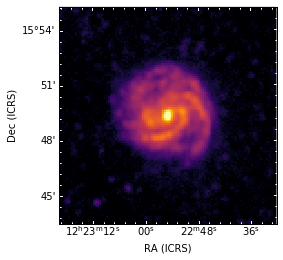

In [19]:
print("Original 250um Image")
fitsImage.quicklookPlot(stretch='log', cmap='inferno', hide_colourbar=True, recentre={"RA":185.72875*u.degree, "DEC":15.8225*u.degree, "rad":6.0*u.arcmin})

Smooth and Reprojected 250um Image


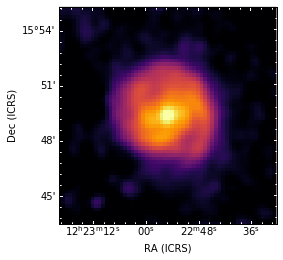

In [20]:
print("Smooth and Reprojected 250um Image")
reproSmo250.quicklookPlot(stretch='log', cmap='inferno', hide_colourbar=True, recentre={"RA":185.72875*u.degree, "DEC":15.8225*u.degree, "rad":6.0*u.arcmin})

500um Image


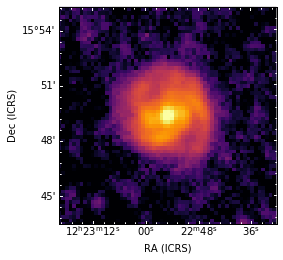

In [21]:
print("500um Image")
image500.quicklookPlot(stretch='log', cmap='inferno', hide_colourbar=True, recentre={"RA":185.72875*u.degree, "DEC":15.8225*u.degree, "rad":6.0*u.arcmin})

<h2>Saving the astro image</h2>

The astroImage object can be saved to a fits file, using the saveToFits method. This method takes the path to the location where you want to save the file, and you can allow the method to overwrite an exisiting file (just the same as astropy).

In [ ]:
reproSmo250.saveToFits(pj(folder,"reproSmo250.fits"), overwrite=True)

<h2>Other Advanced Methods</h2>

There are also some more advance methods described in other notebooks, these are:
 - Colour-correct -> apply colour-corrections to the map
 - Central Wavelength Adjust -> Adjust the central wavelength assuming a model.
 - FFT combine -> Our method for 'feathering' FIR/sub-mm images to combine low and high-resolution images.